In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import scipy
import scanpy as sc
import scvi
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD as SVD

sc.set_figure_params(figsize=(4, 4))

In [2]:
adata = sc.read_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/cellid_annotated_sketch.h5ad")

## See cell types

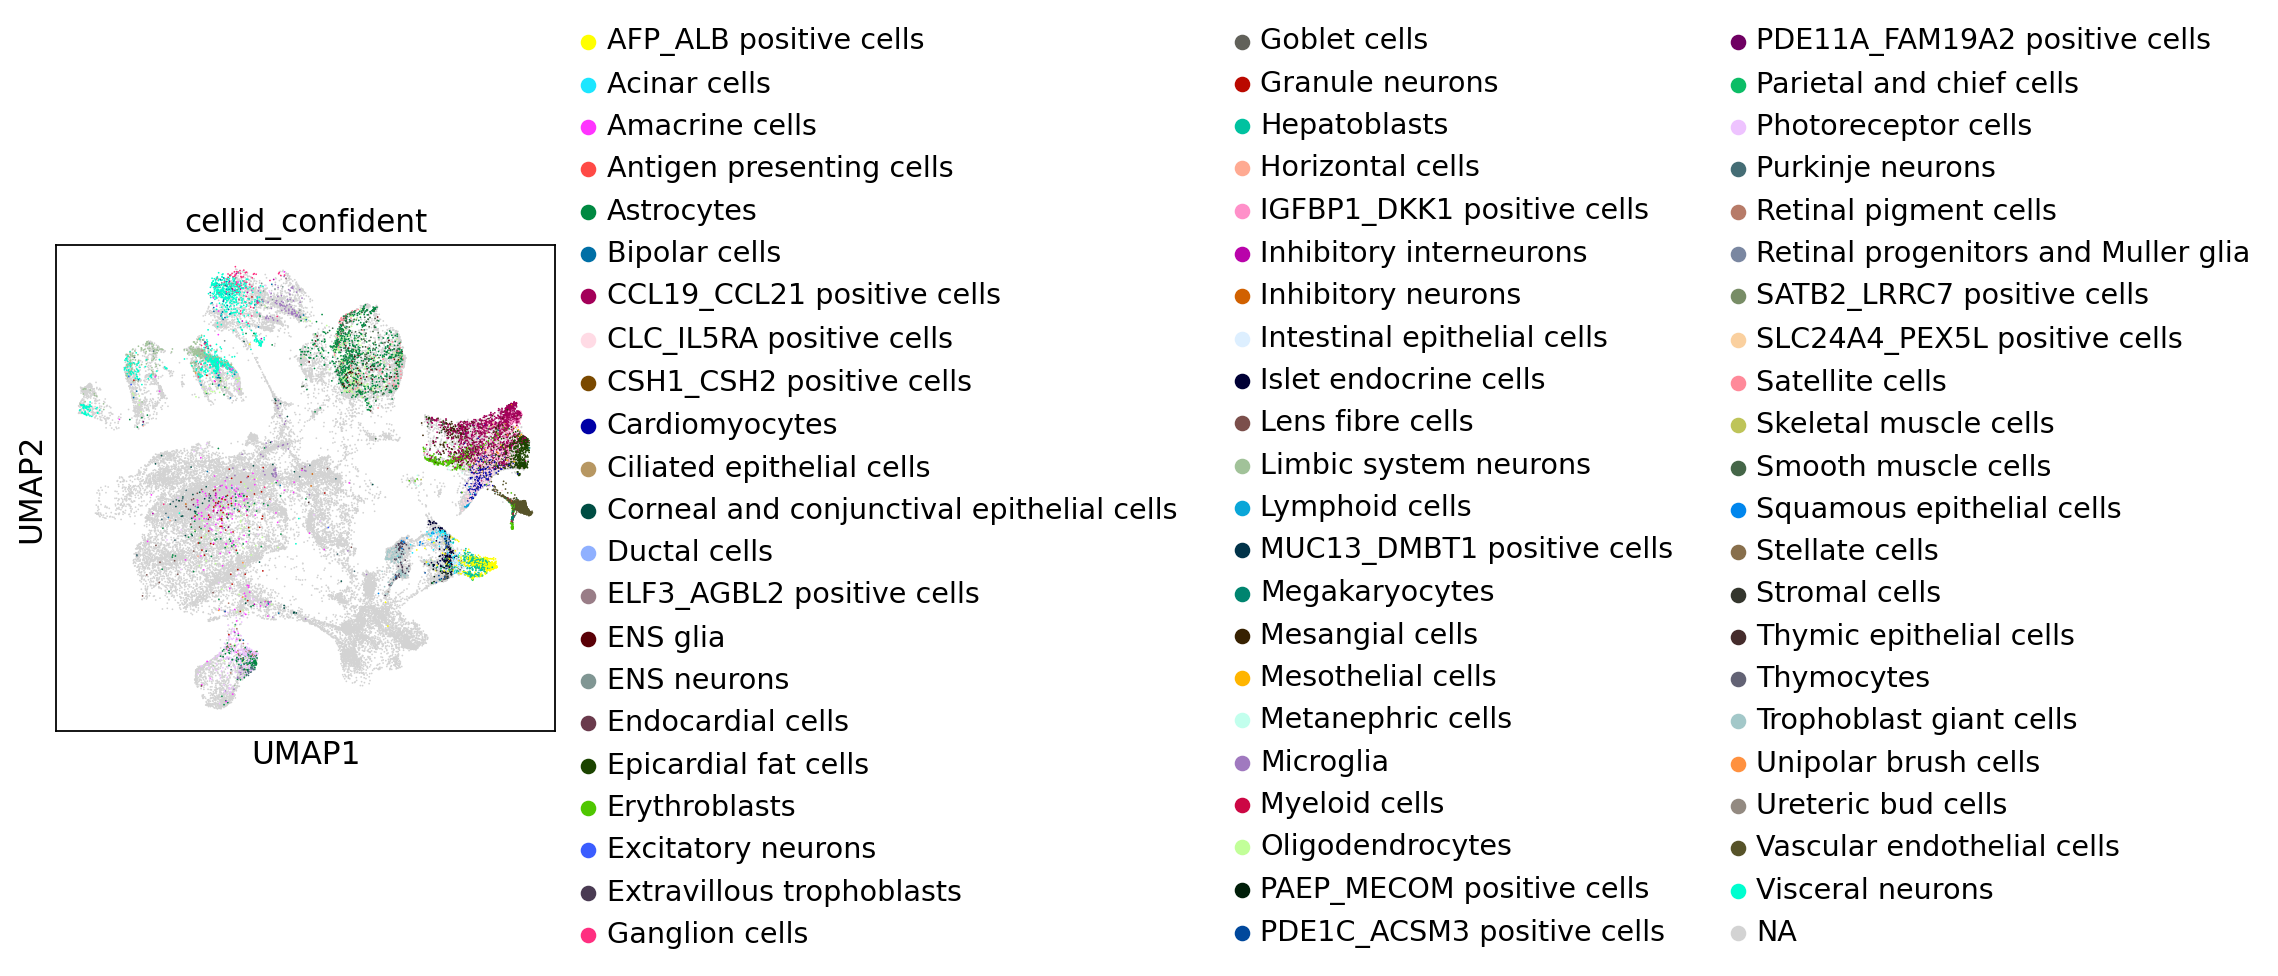

In [3]:
sc.pl.umap(adata, color="cellid_confident")

## Aggregate

Get mean expression per cell type

In [8]:
adata_confident = adata[~pd.isna(adata.obs['cellid_confident'])]

In [10]:
scran_adata = sc.read_h5ad("/project2/gilad/ktayeb/ebqtl-workflowr/output/proc/EB_high_pass_filtered_normalized.h5ad")

In [12]:
scran_adata = scran_adata[adata_confident.obs.index]

In [16]:
onehot = OneHotEncoder(sparse=True).fit_transform(adata_confident.obs[['cellid_confident']])
n_cells = onehot.sum(axis=0)

In [17]:
pseudobulk_sum = scran_adata.X.transpose() * onehot

In [18]:
pseudobulk_mean = pseudobulk_sum / n_cells

In [20]:
pseudobulk_mean = pd.DataFrame(pseudobulk_mean, 
             index=scran_adata.var_names, columns=adata_confident.obs['cellid_confident'].astype("category").cat.categories)

In [56]:
pseudobulk_mean.to_csv("/project2/gilad/jpopp/ebQTL/data/static/highpass_cellid_confident/mashr/pseudobulk_per_celltype.tsv",
                  sep="\t", index_label="gene")

pseudobulk_mean

In [40]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

hvg = intersection(list(adata.var_names), list(pseudobulk_mean.index))

In [45]:
pseudobulk_mean_hvg = pseudobulk_mean.loc[adata.var_names]

In [57]:
pseudobulk_mean_hvg.to_csv("/project2/gilad/jpopp/ebQTL/data/static/highpass_cellid_confident/mashr/pseudobulk_per_celltype_hvg.tsv",
                  sep="\t", index_label="gene")

## PCA

In [36]:
pseudobulk_mean_hvg = pd.read_csv("/project2/gilad/jpopp/ebQTL/data/static/highpass_cellid_confident/mashr/pseudobulk_per_celltype_hvg.tsv", 
                                  sep="\t", index_col="gene")

Set each gene to have mean 0

In [37]:
pseudobulk_mean_hvg = pseudobulk_mean_hvg.sub(pseudobulk_mean_hvg.mean(axis=1), axis=0)

Filter to genes with non-zero variance

In [45]:
pseudobulk_mean_hvg = pseudobulk_mean_hvg[~np.isclose(pseudobulk_mean_hvg.std(axis=1), 0)]

Scale so each gene has unit variance

In [61]:
pseudobulk_mean_hvg = pseudobulk_mean_hvg.divide(pseudobulk_mean_hvg.std(axis=1), axis=0)

In [188]:
pseudobulk_mean_hvg.to_csv("/project2/gilad/jpopp/ebQTL/data/static/highpass_cellid_confident/mashr/pseudobulk_per_celltype_hvg_normalized.tsv",
                  sep="\t", index_label="gene")

Run PCA

In [76]:
dimred = SVD(50).fit(pseudobulk_mean_hvg)

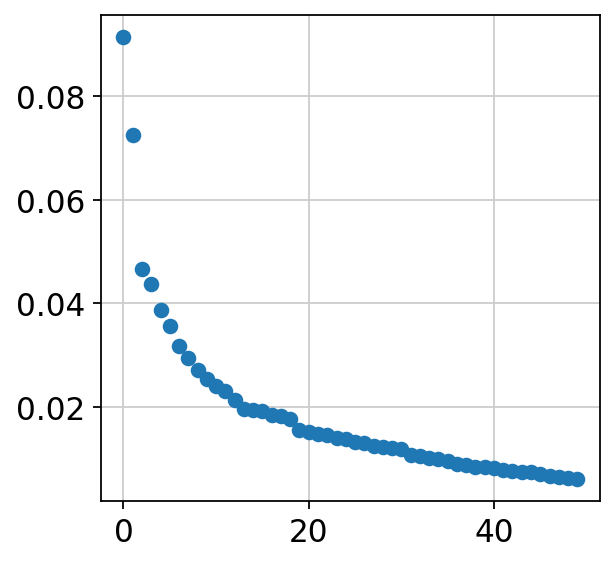

In [77]:
plt.plot(dimred.explained_variance_ratio_, "o")

What is PC1 picking up on?

In [72]:
dimred_fit = PCA(50).fit_transform(pseudobulk_mean_hvg)

In [82]:
pseudobulk_mean_hvg.columns

Index(['AFP_ALB positive cells', 'Acinar cells', 'Amacrine cells',
       'Antigen presenting cells', 'Astrocytes', 'Bipolar cells',
       'CCL19_CCL21 positive cells', 'CLC_IL5RA positive cells',
       'CSH1_CSH2 positive cells', 'Cardiomyocytes',
       'Ciliated epithelial cells',
       'Corneal and conjunctival epithelial cells', 'Ductal cells',
       'ELF3_AGBL2 positive cells', 'ENS glia', 'ENS neurons',
       'Endocardial cells', 'Epicardial fat cells', 'Erythroblasts',
       'Excitatory neurons', 'Extravillous trophoblasts', 'Ganglion cells',
       'Goblet cells', 'Granule neurons', 'Hepatoblasts', 'Horizontal cells',
       'IGFBP1_DKK1 positive cells', 'Inhibitory interneurons',
       'Inhibitory neurons', 'Intestinal epithelial cells',
       'Islet endocrine cells', 'Lens fibre cells', 'Limbic system neurons',
       'Lymphoid cells', 'MUC13_DMBT1 positive cells', 'Megakaryocytes',
       'Mesangial cells', 'Mesothelial cells', 'Metanephric cells',
       'Microglia

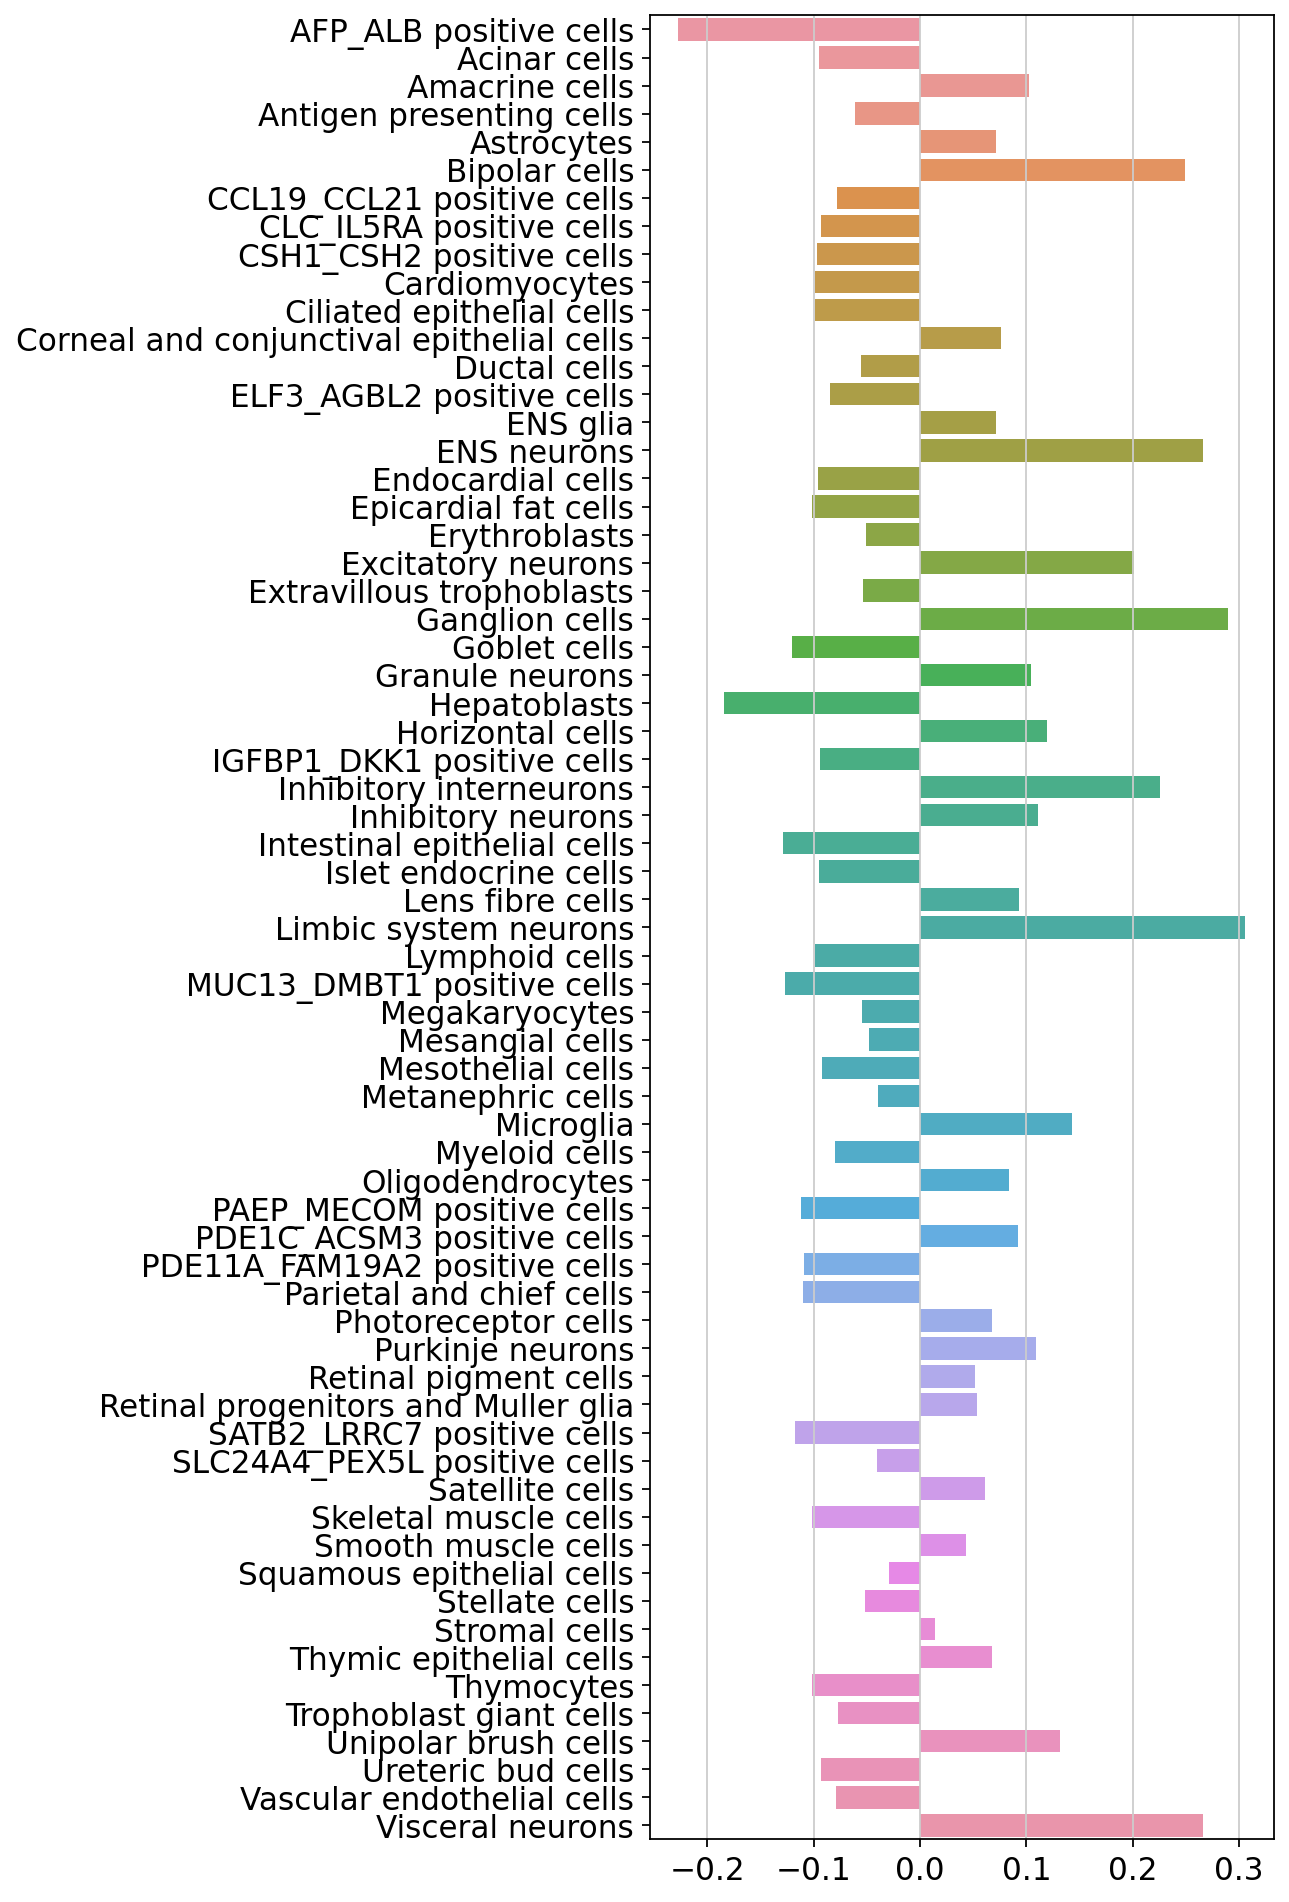

In [88]:
plt.figure(figsize = (5,15))
ax = sns.barplot(y=pseudobulk_mean_hvg.columns, x=dimred.components_[0,:])

This looks very promising, but for clarity I am going to color by germ layer so that any outliers pop out

In [111]:
ref = pd.read_csv("/project2/gilad/katie/ebQTL/FetalReferenceCellTypes_GermLayerAnnotations.csv", header=0).drop(columns="Notes")
ref

,cell type,Germ layer
0,Astrocytes,Neural crest
1,Astrocytes,Ectoderm
2,Microglia,Neural crest
3,Microglia,Ectoderm
4,CCL19_CCL21 positive cells,Mesoderm
...,...,...
84,Lymphatic endothelial cells,Mesoderm
85,Ureteric bud cells,Endoderm
86,Bronchiolar and alveolar epithelial cells,Endoderm
87,Neuroendocrine cells,Ectoderm


In [112]:
ref['color'] = ref['Germ layer'].replace(to_replace = {'Ectoderm': 'blue',
                                                       'Neural crest': 'green',
                                                       'Endoderm': 'yellow',
                                                       'Mesoderm': 'red'})

Note which cell types couldn't be uniquely assigned to a germ layer

In [135]:
ambiguous_celltypes = list(ref.value_counts('cell type').index[ref.value_counts('cell type') > 1])

In [138]:
ref['color'] = np.where(ref['cell type'].isin(ambiguous_celltypes), 'gray', ref['color'])
ref

,cell type,Germ layer,color
0,Astrocytes,Neural crest,gray
1,Astrocytes,Ectoderm,gray
2,Microglia,Neural crest,gray
3,Microglia,Ectoderm,gray
4,CCL19_CCL21 positive cells,Mesoderm,red
...,...,...,...
84,Lymphatic endothelial cells,Mesoderm,red
85,Ureteric bud cells,Endoderm,yellow
86,Bronchiolar and alveolar epithelial cells,Endoderm,yellow
87,Neuroendocrine cells,Ectoderm,gray


In [172]:
my_cmap = ref.drop(columns="Germ layer").drop_duplicates().rename(columns={"cell type": "celltype"})
my_cmap = my_cmap[my_cmap['celltype'].isin(pseudobulk_mean_hvg.columns)]
my_cmap.celltype = my_cmap.celltype.astype("category")
my_cmap.celltype.cat.set_categories(pseudobulk_mean_hvg.columns, inplace=True)
my_cmap = my_cmap.sort_values("celltype")

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]),
 [Text(0, 0, 'AFP_ALB positive cells'),
  Text(0, 1, 'Acinar cells'),
  Text(0, 2, 'Amacrine cells'),
  Text(0, 3, 'Antigen presenting cells'),
  Text(0, 4, 'Astrocytes'),
  Text(0, 5, 'Bipolar cells'),
  Text(0, 6, 'CCL19_CCL21 positive cells'),
  Text(0, 7, 'CLC_IL5RA positive cells'),
  Text(0, 8, 'CSH1_CSH2 positive cells'),
  Text(0, 9, 'Cardiomyocytes'),
  Text(0, 10, 'Ciliated epithelial cells'),
  Text(0, 11, 'Corneal and conjunctival epithelial cells'),
  Text(0, 12, 'Ductal cells'),
  Text(0, 13, 'ELF3_AGBL2 positive cells'),
  Text(0, 14, 'ENS glia'),
  Text(0, 15, 'ENS neurons'),
  Text(0, 16, 'Endocardial cells'),
  Text(0, 17, 'Epicardial fat cells'),
  Text(0, 18, 'Erythroblasts'),


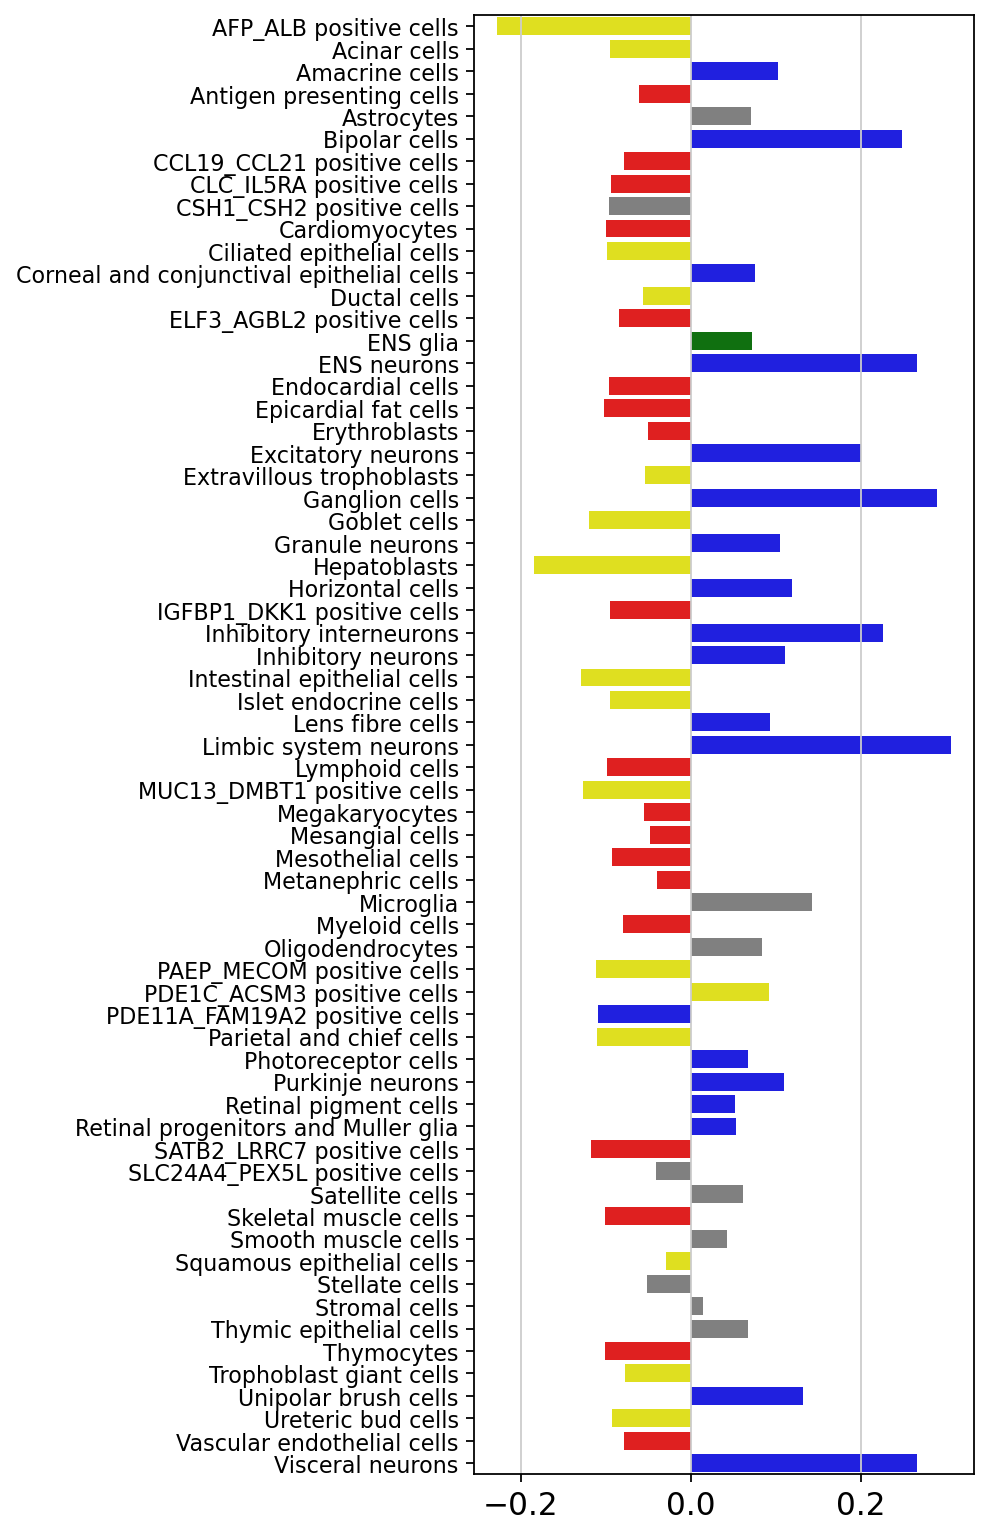

In [184]:
sns.set_palette(my_cmap['color'])
plt.figure(figsize = (4,12))
ax = sns.barplot(y=pseudobulk_mean_hvg.columns, x=dimred.components_[0,:])
plt.yticks(fontsize=10)

What is the second principal component picking up on?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]),
 [Text(0, 0, 'AFP_ALB positive cells'),
  Text(0, 1, 'Acinar cells'),
  Text(0, 2, 'Amacrine cells'),
  Text(0, 3, 'Antigen presenting cells'),
  Text(0, 4, 'Astrocytes'),
  Text(0, 5, 'Bipolar cells'),
  Text(0, 6, 'CCL19_CCL21 positive cells'),
  Text(0, 7, 'CLC_IL5RA positive cells'),
  Text(0, 8, 'CSH1_CSH2 positive cells'),
  Text(0, 9, 'Cardiomyocytes'),
  Text(0, 10, 'Ciliated epithelial cells'),
  Text(0, 11, 'Corneal and conjunctival epithelial cells'),
  Text(0, 12, 'Ductal cells'),
  Text(0, 13, 'ELF3_AGBL2 positive cells'),
  Text(0, 14, 'ENS glia'),
  Text(0, 15, 'ENS neurons'),
  Text(0, 16, 'Endocardial cells'),
  Text(0, 17, 'Epicardial fat cells'),
  Text(0, 18, 'Erythroblasts'),


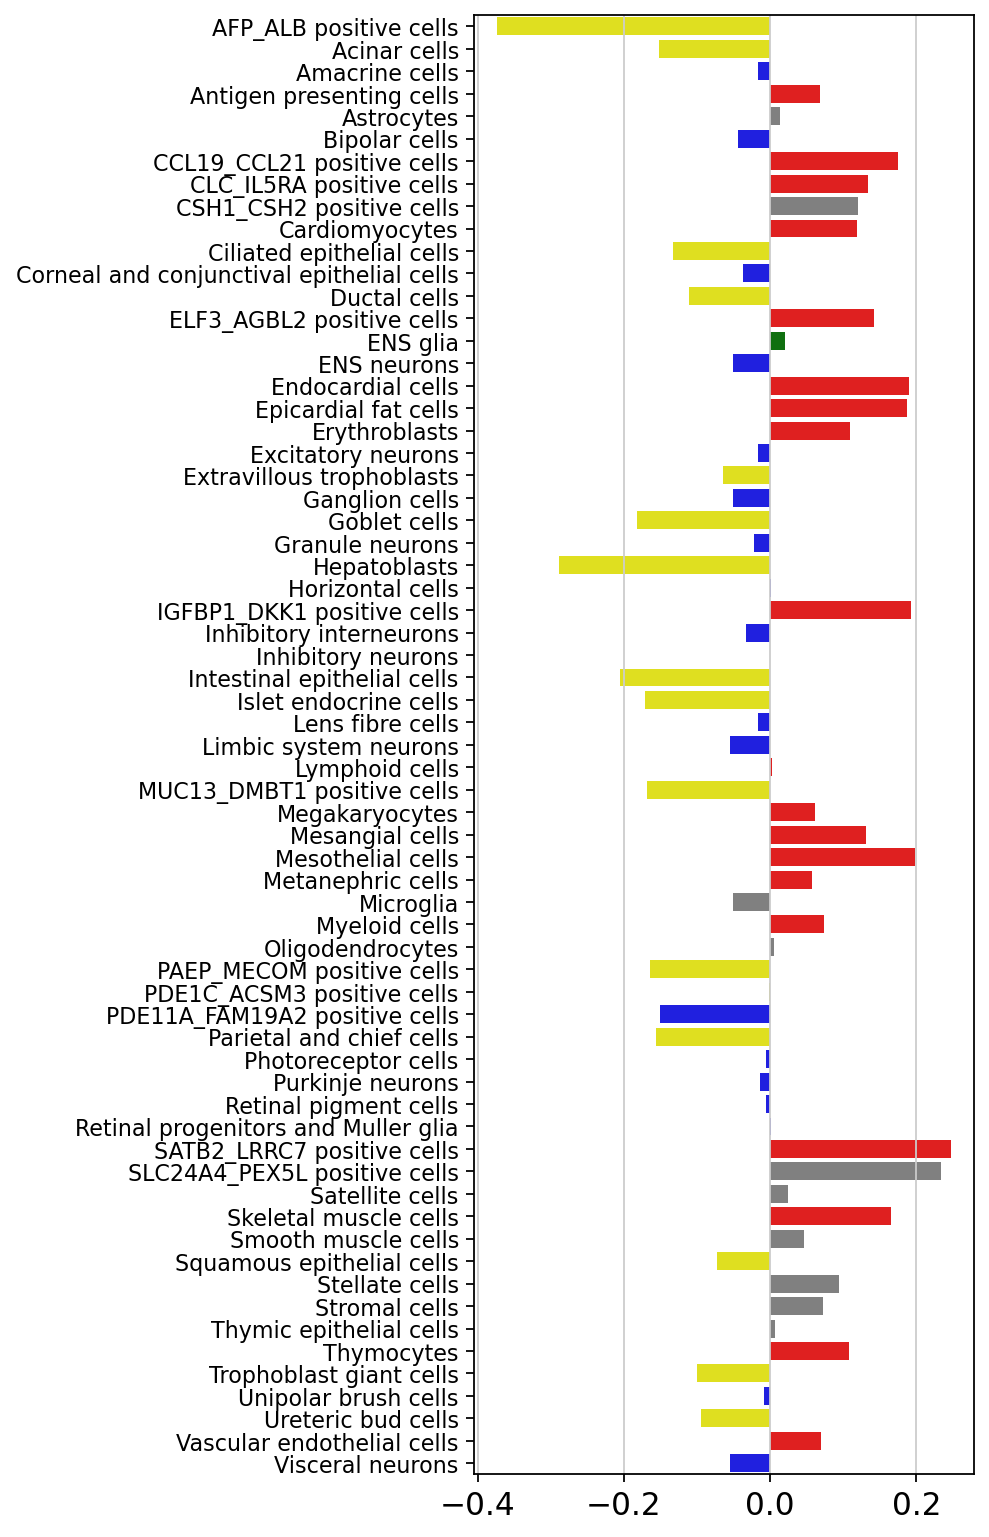

In [186]:
sns.set_palette(my_cmap['color'])
plt.figure(figsize = (4,12))
ax = sns.barplot(y=pseudobulk_mean_hvg.columns, x=dimred.components_[1,:])
plt.yticks(fontsize=10)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]),
 [Text(0, 0, 'AFP_ALB positive cells'),
  Text(0, 1, 'Acinar cells'),
  Text(0, 2, 'Amacrine cells'),
  Text(0, 3, 'Antigen presenting cells'),
  Text(0, 4, 'Astrocytes'),
  Text(0, 5, 'Bipolar cells'),
  Text(0, 6, 'CCL19_CCL21 positive cells'),
  Text(0, 7, 'CLC_IL5RA positive cells'),
  Text(0, 8, 'CSH1_CSH2 positive cells'),
  Text(0, 9, 'Cardiomyocytes'),
  Text(0, 10, 'Ciliated epithelial cells'),
  Text(0, 11, 'Corneal and conjunctival epithelial cells'),
  Text(0, 12, 'Ductal cells'),
  Text(0, 13, 'ELF3_AGBL2 positive cells'),
  Text(0, 14, 'ENS glia'),
  Text(0, 15, 'ENS neurons'),
  Text(0, 16, 'Endocardial cells'),
  Text(0, 17, 'Epicardial fat cells'),
  Text(0, 18, 'Erythroblasts'),


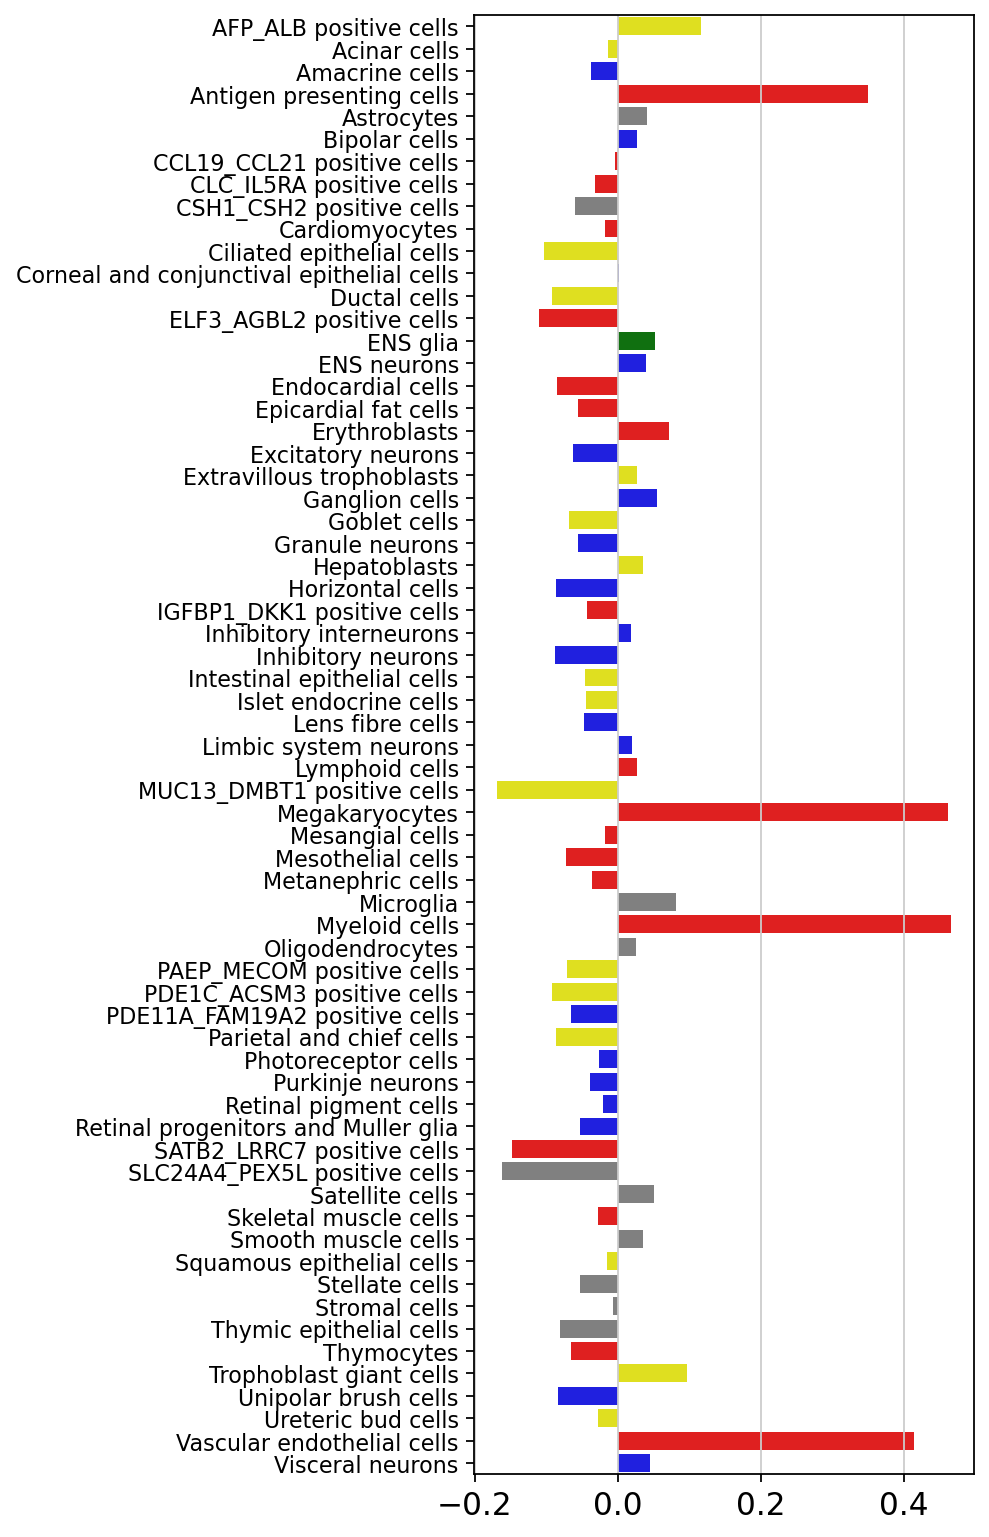

In [187]:
sns.set_palette(my_cmap['color'])
plt.figure(figsize = (4,12))
ax = sns.barplot(y=pseudobulk_mean_hvg.columns, x=dimred.components_[2,:])
plt.yticks(fontsize=10)

These look great. Need to save the 